# ABDA HW4
| Name        | Id         |
| -------------|:----------:|
| Noam Siegel    | 314475062 |

### Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
from torch.distributions import constraints
from tqdm import tqdm

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta, AutoNormal
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, MCMC, NUTS, predictive
from pyro.infer import Predictive

pyro.enable_validation(True)
pyro.set_rng_seed(0)

## Question 1: Unsupervised exploration of Iris Dataset

The Iris dataset includes the sepal and petal length and width, for three species of irides: setosa, versicolor, virginica. 

How well do the features separate species?

## The data
We download the data from the course's website.

We observe:

1. We see that the data is exactly balanced (50 samples per species).
2. The setosa is very different from the versicolor/virginica in terms of petal length/width.
3. The petal lengths and petal widths are highly correlated.

In [ ]:
url = 'https://bgu-abda.bitbucket.io/homework/04iris.csv'
df = pd.read_csv(url)
df = df.rename({'sepal length (cm)' : 'sepal_length', 'sepal width (cm)' : 'sepal_width',
                'petal length (cm)' : 'petal_length', 'petal width (cm)' : 'petal_width'}, axis='columns')
df["label"] = df['species'].astype('category').cat.codes

df.sample(8)

,sepal_length,sepal_width,petal_length,petal_width,species,label
114,5.8,2.8,5.1,2.4,virginica,2
62,6.0,2.2,4.0,1.0,versicolor,1
33,5.5,4.2,1.4,0.2,setosa,0
107,7.3,2.9,6.3,1.8,virginica,2
7,5.0,3.4,1.5,0.2,setosa,0
100,6.3,3.3,6.0,2.5,virginica,2
40,5.0,3.5,1.3,0.3,setosa,0
86,6.7,3.1,4.7,1.5,versicolor,1


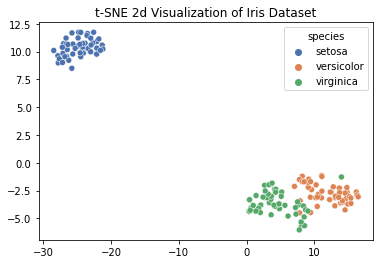

In [ ]:
features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
X = torch.tensor(df[features].values).float()
tsne = TSNE(n_components=2, init='pca')
X_embedded = tsne.fit_transform(X)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df.species, palette="deep").set(title="t-SNE 2d Visualization of Iris Dataset");

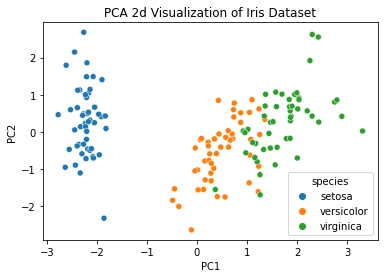

In [ ]:
sclr = StandardScaler()
X = sclr.fit_transform(X)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
sns.scatterplot(x=principalComponents[:,0], y=principalComponents[:,1], hue=df.species).set(title="PCA 2d Visualization of Iris Dataset", xlabel="PC1", ylabel="PC2");

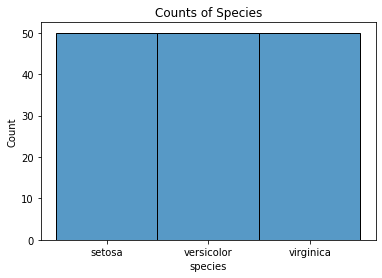

In [ ]:
sns.histplot(data=df.species).set(title="Counts of Species");

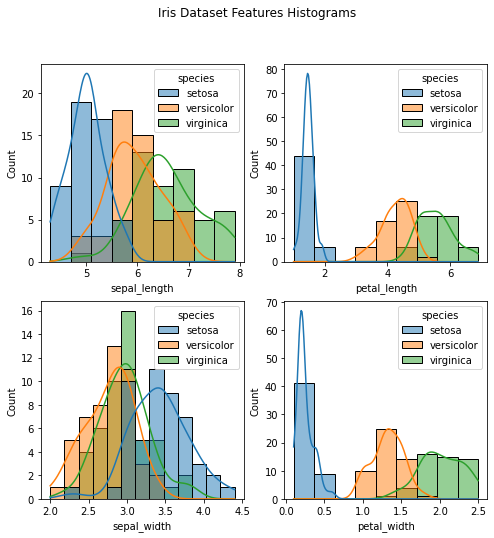

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Iris Dataset Features Histograms')
kde = True
sns.histplot(ax=axes[0,0], data=df, x='sepal_length', kde=kde, hue="species")
sns.histplot(ax=axes[1,0], data=df, x='sepal_width', kde=kde, hue="species")
sns.histplot(ax=axes[0,1], data=df, x='petal_length', kde=kde, hue="species")
sns.histplot(ax=axes[1,1], data=df, x='petal_width', kde=kde, hue="species");

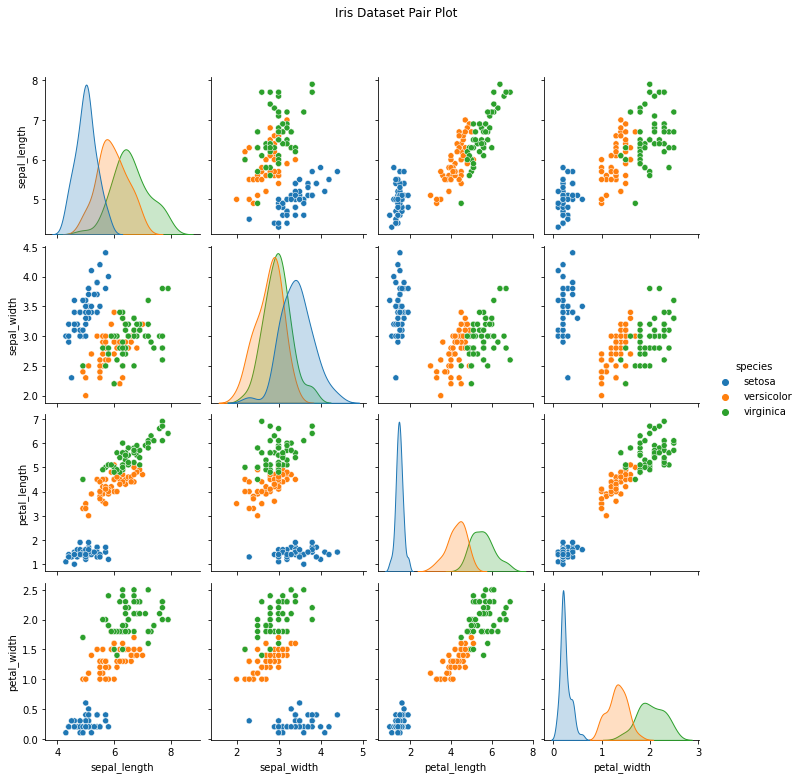

In [ ]:
g = sns.pairplot(df.drop(["label"], axis=1), hue="species")
g.fig.suptitle("Iris Dataset Pair Plot", y=1.08);

## Defining the Model
We will define a 4-dimensional Gaussian Mixture Model with K=3 clusters.

In [ ]:
D = 4  # dimension of each data point
K = 3  # number of clusters


In [ ]:
@config_enumerate(default='parallel')
@poutine.broadcast
def model(data):
    # Global variables.
    weights = pyro.param('weights', torch.ones(K) / K, constraint=constraints.simplex)
    scales = pyro.param('scales', torch.rand(K, D, D) * torch.eye(D).expand(K, D, D), constraint=constraints.positive)
    locs = pyro.param('locs', torch.rand((K, D)))

    with pyro.iarange('data', data.size(0)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(torch.outer(torch.ones(len(data)), weights)))
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scales[assignment]), obs=data)
    return weights, scales, locs


@config_enumerate(default="parallel")
# @poutine.broadcast
def full_guide(data):
    with pyro.iarange('data', data.size(0)) as ind:
        # Local variables.
        assignment_probs = pyro.param('assignment_probs', torch.outer(torch.ones(len(data)), torch.ones(K) / K),
                                      constraint=constraints.simplex)
        pyro.sample('assignment', dist.Categorical(assignment_probs), infer={"enumerate": "sequential"})


def initialize(data):
    pyro.clear_param_store()

    optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
    elbo = TraceEnum_ELBO(max_iarange_nesting=1)
    svi = SVI(model, full_guide, optim, loss=elbo)

    # Initialize weights to uniform.
    pyro.param('auto_weights', torch.ones(K) / K, constraint=constraints.simplex)

    # Assume half of the data variance is due to intra-component noise.
    var = (data.var() / 2).sqrt()
    pyro.param('auto_scale', torch.tensor([var]*6), constraint=constraints.positive)

    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)])

    loss = svi.loss(model, full_guide, data)

    return loss, svi
    

def plot(X, pca=pca, mus=None, sigmas=None, colors='black'):
    # Create figure
    fig = plt.figure()

    # Plot data
    # x = data[:, 0]
    # y = data[:, 1]
    PCs = pca.transform(X)
    plt.scatter(PCs[:, 0], PCs[:, 1], 24, c=colors)

    # Plot cluster centers
    if mus is not None:
        mus_2d = pca.transform(mus.data)
        x = [float(m[0]) for m in mus_2d]
        y = [float(m[1]) for m in mus_2d]
        plt.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    if sigmas is not None:
        for sig_ix in range(K):
            ax = fig.gca()
            cov = np.array(sigmas[sig_ix])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                          width=lam[0]*4, height=lam[1]*4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)
    fig.suptitle("PCA 2d Visualization of MAP Assignments")
    # Save figure
    return fig






## Inference of the Posterior

We perform inference by Variationla

In [ ]:
pyro.clear_param_store()
global_guide = AutoNormal(poutine.block(model, expose=['weights', 'locs', 'scales']))
# global_guide = config_enumerate(global_guide, 'parallel')
X = torch.tensor(X).float()
_, svi = initialize(X)
for i in tqdm(range(1001)):
    svi.step(X)

locs = pyro.param('locs')
scales = pyro.param('scales')
weights = pyro.param('weights')
assignment_probs = pyro.param('assignment_probs')

assignments = np.uint8(torch.argmax(assignment_probs, dim=1))

100%|██████████| 1001/1001 [00:17<00:00, 56.22it/s]


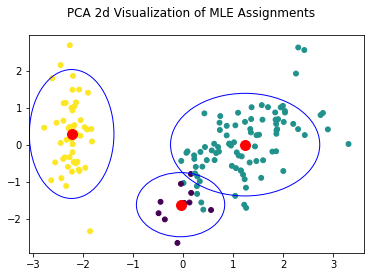

In [ ]:
plot(X, pca, locs.data, scales.data, assignments);

In [ ]:
predictive = Predictive(model, guide=global_guide, num_samples=800)
samples = predictive(X)

In [ ]:
samples

{'assignment': tensor([[1, 1, 2,  ..., 0, 2, 1],
         [2, 0, 1,  ..., 1, 1, 1],
         [1, 0, 0,  ..., 2, 0, 2],
         ...,
         [1, 2, 1,  ..., 1, 1, 2],
         [1, 1, 1,  ..., 0, 1, 1],
         [2, 2, 2,  ..., 1, 1, 1]]),
 'obs': tensor([[[-0.9007,  1.0190, -1.3402, -1.3154],
          [-1.1430, -0.1320, -1.3402, -1.3154],
          [-1.3854,  0.3284, -1.3971, -1.3154],
          ...,
          [ 0.7957, -0.1320,  0.8196,  1.0539],
          [ 0.4322,  0.7888,  0.9333,  1.4488],
          [ 0.0687, -0.1320,  0.7628,  0.7907]],
 
         [[-0.9007,  1.0190, -1.3402, -1.3154],
          [-1.1430, -0.1320, -1.3402, -1.3154],
          [-1.3854,  0.3284, -1.3971, -1.3154],
          ...,
          [ 0.7957, -0.1320,  0.8196,  1.0539],
          [ 0.4322,  0.7888,  0.9333,  1.4488],
          [ 0.0687, -0.1320,  0.7628,  0.7907]],
 
         [[-0.9007,  1.0190, -1.3402, -1.3154],
          [-1.1430, -0.1320, -1.3402, -1.3154],
          [-1.3854,  0.3284, -1.3971, -1.3154

In [ ]:
samples.keys()

dict_keys(['assignment', 'obs'])

In [ ]:
mus_2d = pca.transform(locs.data)
x = [float(m[0]) for m in mus_2d]
y = [float(m[1]) for m in mus_2d]

NameError: name 'data' is not defined

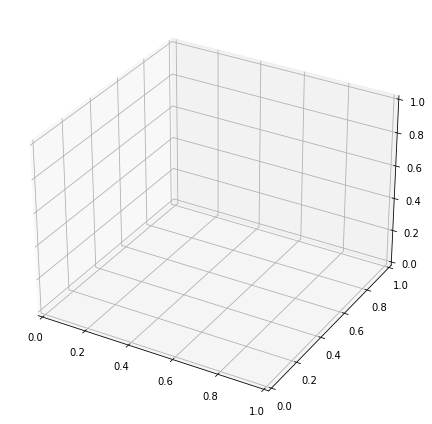

In [ ]:
plt.rcParams["figure.figsize"] = [6.00, 6]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = data[:,0]
y = data[:,1]
z = data[:,2]
c = data[:,3]
img = ax.scatter(x, y, z, c=c, cmap='YlOrRd', alpha=1)
plt.show()